In [2]:
# -------------------------------------------------------------------------------------------------- #
# Importare moduli interi
import numpy as np
import pandas as pd
import nltk
import re
import tqdm
import sys
import json

# importare parti di moduli
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

from os import listdir
from os.path import isfile, join

from string import punctuation

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn import linear_model,metrics
# Importing TSNE.
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,_kl_divergence)
#from sklearn.utils.extmath import _ravel
# Random state we define this random state to use this value in TSNE which is a randmized algo.
RS = 25111993

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from bs4 import BeautifulSoup

# Importing for graphics and plots.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
rc={"lines.linewidth": 2.5})

import bokeh.plotting as bp
from bokeh.models import HoverTool
from bokeh.plotting import save

In [3]:
###FUNZIONI NECESSARIE PER ESTRAZIONE DATI DAGLI ARTICOLI PER POI CREARE LA TERM DOCUMENT MATRIX
# ------------------------------------------------------------------------------------------------- #
# prende in input un'articolo e esegue delle modifiche ai campi di interesse utilizzando funzioni e oggetti passati come parametri
def news_analyzer(news, tokenizer, stemmer, stop_words=[]):
    campi_interesse = ['testo','titolo_articolo','sottotitolo']
    
    for campo in campi_interesse:
        news[campo] = BeautifulSoup(news[campo], "lxml").get_text()                                 # rimozione tag html
        news[campo] = news[campo].replace("'"," ")                                                  # rimossi apostrofi
        news[campo] = re.sub("http\S+", " link ", news[campo])                                      # rimossi link
        news[campo] = tokenizer.tokenize(news[campo])                                               # campi tokenizzati
        news[campo] = [token for token in news[campo] if not token.isdigit() and token not in stop_words]# tokenizzazione e rimozione delle stopwords
        news[campo] = [stemmer.stem(token) for token in news[campo] if not token.isdigit() and token not in stop_words]# stemming

    return news                                                                                     #ritorna l'articolo processato

# ------------------------------------------------------------------------------------------------- #
# effettua il preprocessamento di tutti gli articoli dell'insieme di trainig
def preproc(X):
    nltk.download("stopwords")
    stop_words = stopwords.words('italian') + list(punctuation)
    stemmer = SnowballStemmer("italian")
    tokenizer = TweetTokenizer(preserve_case=False,strip_handles=True)
    return [news_analyzer(news, tokenizer, stemmer, stop_words) for news in tqdm.tqdm(X)]

# ------------------------------------------------------------------------------------------------- #
# ottieni gli articoli
def get_news(news_dir):
    data = []
    onlyfiles = [f for f in listdir(news_dir) if isfile(join(news_dir, f))]
    for articolo in onlyfiles:
        docJson = open(news_dir+articolo,"r")
        jsonData = json.loads(docJson.read())
        data.append(jsonData)
        docJson.close()
    return data

# ------------------------------------------------------------------------------------------------- #

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# ------------------------------------------------------------------------------------------------- #
def distribuzione_frequenze(docs,y):
    no_features = 10000
    vectorizer = CountVectorizer(max_df=1.0,min_df=4, max_features=no_features, lowercase=False, binary=True, encoding='utf-8')
    tf = vectorizer.fit_transform(docs)
    tdf = np.sum(tf.toarray(), axis=0)
    df ={}
    for i in tdf:
        if i in df:
            df[i] += 1
        else:
            df[i] = 1
    freqs = []
    for item in sorted(df.keys()):
        freqs +=([item]*df[item])
    dfdf = pd.DataFrame(freqs,columns=["df"])
    plt.figure(num=1,figsize=(18, 10))
    sns.countplot(x="df", data = dfdf)

# ------------------------------------------------------------------------------------------------- #
def train_model(classifier, train_features, train_cats, test_features, test_cats):
    # fit the training dataset on the classifier
    classifier.fit(train_features, train_cats)
    
    # predire le categorie sull'insieme di test
    predictions = classifier.predict(test_features)
    
    return metrics.accuracy_score(predictions, test_cats)

# ------------------------------------------------------------------------------------------------- #    
# An user defined function to create scatter plot of vectors
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 8))

    # We create a scatter plot.
    f = plt.figure(figsize=(32, 32))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=120,
                    c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each cluster.
    txts = []
    for i in range(18):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=50)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts


In [5]:
economia = get_news("./articoli_economia/")
cultura = get_news("./articoli_cultura/")
tech = get_news("./articoli_tech/")
politica = get_news("./articoli_politica/")
for articolo in economia:
    articolo['categoria'] = "Economia"
for articolo in cultura:
    articolo['categoria'] = "Cultura"
for articolo in tech:
    articolo['categoria'] = "Tech"
for articolo in politica:
    articolo['categoria'] = "Politica"
dati_preprocessati =  preproc(tech + politica + cultura + economia)

seed = 2
train_documents,test_documents = train_test_split(dati_preprocessati,random_state=seed)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cristy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 799/799 [00:04<00:00, 184.33it/s]


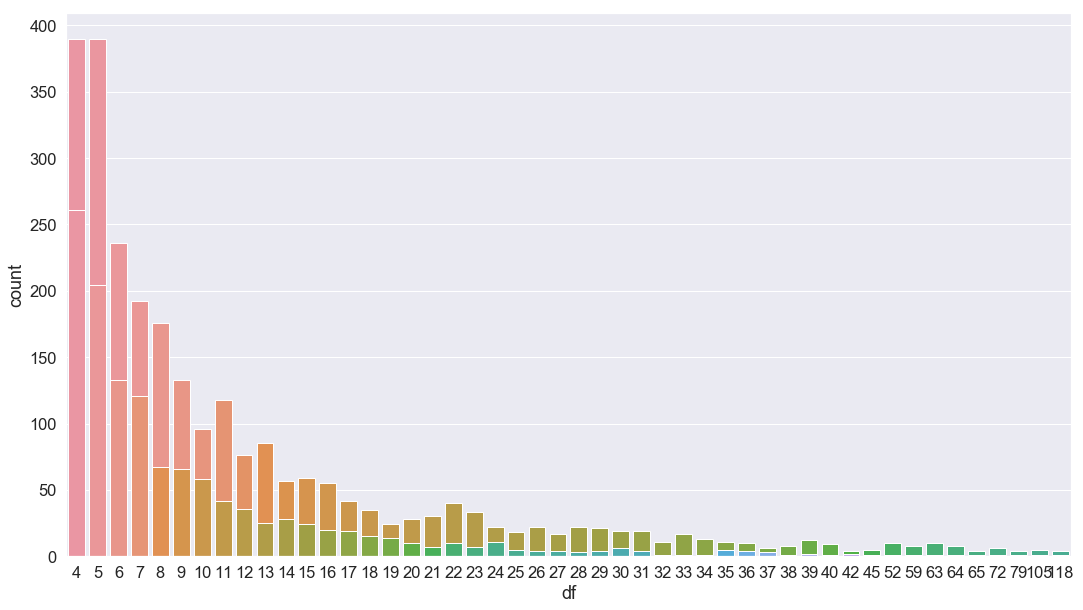

In [6]:
#####Costruisci la term document matrix e poi cerca
docs_texts = [' '.join([word for word in x['testo']] + x['tags'] + x['sottotitolo'] + x['titolo_articolo']) for x in dati_preprocessati]
train_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in train_documents]
test_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in test_documents]

docs_cats = [x["categoria"] for x in dati_preprocessati]
train_cats = [x["categoria"] for x in train_documents]
test_cats = [x["categoria"] for x in test_documents]

no_features = 300000
tf_vectorizer = CountVectorizer(ngram_range=(10,10), min_df=1,encoding='utf-8',max_features=no_features, lowercase=True).fit(docs_texts)
train_tf = tf_vectorizer.transform(train_texts)
test_tf = tf_vectorizer.transform(test_texts)
tot_tf = tf_vectorizer.transform(docs_texts)

distribuzione_frequenze(train_texts,"train")
distribuzione_frequenze(test_texts,"test")

In [8]:
df = pd.DataFrame(tot_tf.toarray().transpose(), index = tf_vectorizer.get_feature_names())
print(df.shape)



(34344, 799)


In [9]:
###Creamo i cluster con LDA

no_topics = 4
# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics,max_iter=100, learning_method='online',random_state=0).fit(train_tf)



In [10]:
X_train = lda.transform(train_tf)
#Correction
threshold = 0.1
_idx = np.amax(X_train, axis=1) > threshold  # idx of doc that above the threshold
X_train = X_train[_idx]
X_train.shape

(599, 4)

In [11]:
# Fit the model using t-SNE randomized algorithm
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, init='pca')

In [12]:
# N-D -> 2-D
tsne_lda = tsne_model.fit_transform(X_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 599 samples in 0.007s...
[t-SNE] Computed neighbors for 599 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 599 / 599
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.400822
[t-SNE] KL divergence after 1000 iterations: -0.533431


In [13]:
_topics = X_train
len(_topics)

599

In [14]:
# 20 colors
colormap = np.array([
    "#1f77b4", "#bbc7e8", "#cc7f0e", "#ddbb78"
])

In [15]:
#Then we find the most likely topic for each news:
_lda_keys = []
for i in range(X_train.shape[0]):
  _lda_keys +=  _topics[i].argmax(),

len(_lda_keys)


599

In [16]:
#and get top words for each topic:
n_top_words = 5
topic_summaries = []
topic_word = lda.components_  # all topic words
vocab = tf_vectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
  topic_summaries.append(' '.join(topic_words)) # append!


In [17]:
from plotly.plotly import iplot
import plotly as pl
from plotly.graph_objs import Scatter3d, Data, Marker

# First three dimensions from reduced X VS the Y
walkers = []

trace0 = Scatter3d(
    x=tsne_lda[0:199, 0],
    y=tsne_lda[0:199, 1],
    z=tsne_lda[0:199, 2], 
    marker=Marker(color=colormap[0], colorscale='Portland'),
    mode='markers'
)

trace1 = Scatter3d(
    x=tsne_lda[200:399, 0],
    y=tsne_lda[200:399, 1],
    z=tsne_lda[200:399, 2], 
    marker=Marker(color=colormap[1], colorscale='Portland'),
    mode='markers'
)

trace2 = Scatter3d(
    x=tsne_lda[400:599, 0],
    y=tsne_lda[400:599, 1],
    z=tsne_lda[400:599, 2], 
    marker=Marker(color=colormap[2], colorscale='Portland'),
    mode='markers'
)

trace3 = Scatter3d(
    x=tsne_lda[600:799, 0],
    y=tsne_lda[600:799, 1],
    z=tsne_lda[600:799, 2], 
    marker=Marker(color=colormap[3], colorscale='Portland'),
    mode='markers'
)

walkers.append(trace0)
walkers.append(trace1)
walkers.append(trace2)
walkers.append(trace3)

data = Data(walkers) 
pl.tools.set_credentials_file(username='cristi.gutzu', api_key='S4SFAPdXM3dUxDF0wmxT')
iplot(data, filename = 'pca-cloud')


IndexError: index 2 is out of bounds for axis 1 with size 2

In [18]:
## title = '1024 articoli ANSA'
from bokeh.plotting import figure 
from bokeh.transform import factor_cmap
from bokeh.io import output_notebook, show

print(len(tsne_lda[:,0]))

testi = [x['testo'] for x in dati_preprocessati]
data = { 'x' : tsne_lda[:,0],
         'y' :  tsne_lda[:,1],
        'content': train_cats, 
        'topic_key': [str(x) for x in train_cats]}
 
source = bp.ColumnDataSource(data)

p = figure(plot_width=1100, plot_height=1100, tooltips="content: @content - topic: @topic_key")
index_cmap=factor_cmap('topic_key', palette=colormap, factors=list(set([str(x) for x in cats])) )
p.circle('x', 'y', size=10, source=source, fill_color=index_cmap)


show(p)
list(set([str(x) for x in cats]))


599


NameError: name 'cats' is not defined

In [208]:
#Vogliamo un metodo per ottimizare il parametro del countVectorizer.
#che e' ngarm range, questo parametro vive in N.

from collections import Counter
distr = {"Tech":[], "Politica":[], "Economia":[], "Cultura":[]}
i=0
for idex, doc in enumerate(train_documents):
    topic = (_lda_keys[i])
    distr[doc['categoria']].append(topic)
    i=i+1
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
    lista = [item[1] for item in freq.items()]
    for key, value in freq.items(): 
        print ("% d : % d"%(key, value)) 
        
    return (max(lista)/sum(lista))
    
c1=CountFrequency(distr["Tech"])
print("#######")
c2=CountFrequency(distr["Economia"])
print("#######")

c3=CountFrequency(distr["Politica"])
print("#######")

c4=CountFrequency(distr["Cultura"])

indice = (c1+c2+c3+c4)/4
print(indice)

 2 :  30
 3 :  24
 1 :  42
 0 :  54
#######
 1 :  27
 0 :  35
 2 :  46
 3 :  40
#######
 2 :  43
 0 :  48
 3 :  30
 1 :  33
#######
 1 :  44
 0 :  40
 2 :  33
 3 :  30
0.32045471259756975


In [209]:


# randomly choose a news (within a topic) coordinate as the crucial words coordinate
topic_coord = np.empty((X_train.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
  if not np.isnan(topic_coord).any():
    break
  topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
for i in range(X_train.shape[1]):
  plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
save(plot_lda, '{}.html'.format(title))


NameError: name 'plot_lda' is not defined

In [210]:
help(bp.ColumnDataSource)

Help on class ColumnDataSource in module bokeh.models.sources:

class ColumnDataSource(ColumnarDataSource)
 |  Maps names of columns to sequences or arrays.
 |  
 |  The ``ColumnDataSource`` is a fundamental data structure of Bokeh. Most
 |  plots, data tables, etc. will be driven by a ``ColumnDataSource``.
 |  
 |  If the ``ColumnDataSource`` initializer is called with a single argument that
 |  can be any of the following:
 |  
 |  * A Python ``dict`` that maps string names to sequences of values, e.g.
 |    lists, arrays, etc.
 |  
 |    .. code-block:: python
 |  
 |        data = {'x': [1,2,3,4], 'y': np.ndarray([10.0, 20.0, 30.0, 40.0])}
 |  
 |        source = ColumnDataSource(data)
 |  
 |  .. note::
 |      ``ColumnDataSource`` only creates a shallow copy of ``data``. Use e.g.
 |      ``ColumnDataSource(copy.deepcopy(data))`` if initializing from another
 |      ``ColumnDataSource.data`` object that you want to keep independent.
 |  
 |  * A Pandas ``DataFrame`` object
 |  
 |

In [211]:
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model,metrics

X_train = lda.transform(train_tf)
X_test = lda.transform(test_tf)

accuracy = train_model(DummyClassifier("most_frequent"), X_train, train_cats, X_test, test_cats)
print(accuracy)
accuracy = train_model(linear_model.LogisticRegression(), X_train, train_cats, X_test, test_cats)
print(accuracy)
accuracy = train_model(DecisionTreeClassifier(), X_train, train_cats, X_test, test_cats)#max_depth=50,min_samples_leaf=8
print(accuracy)
accuracy = train_model(LinearDiscriminantAnalysis(), X_train, train_cats, X_test, test_cats)
print(accuracy)

0.23
0.26
0.885
0.26


/home/alex/anaconda3/envs/msbd/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alex/anaconda3/envs/msbd/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alex/anaconda3/envs/msbd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
